In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
from pathlib import Path
import os
from os.path import join
import re
import math
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.rod import ROD

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import shap

In [2]:
import warnings
from sklearn.ensemble import IsolationForest

warnings.filterwarnings("ignore", message="X has feature names, but IsolationForest was fitted without feature names")

# Coleta de Dados

In [3]:
MODULE_PATH = Path().absolute().parent
DATA_PATH = join(MODULE_PATH, "sources/processed")

In [4]:
complete_data = pd.read_csv(join(DATA_PATH, "selected_features_complete_df.csv"))

In [5]:
complete_data["data"] = pd.to_datetime(complete_data["data"])

In [6]:
complete_data = complete_data[complete_data.columns[:10].to_list()]

In [7]:
complete_data.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro
0,2009,1,2009-01-01,0.149600,25.187439,20.299029,76.026835,0,1,0
1,2009,1,2009-01-02,0.305735,24.722086,20.084109,77.689743,0,1,0
2,2009,1,2009-01-03,0.434014,24.058518,19.749311,78.933681,0,1,0
3,2009,1,2009-01-04,0.245052,23.368056,18.715145,77.340627,0,1,0
4,2009,1,2009-01-05,0.201583,23.101135,17.945004,75.597683,0,1,0


# Pré-Processamento

## Definição do Pipeline

In [8]:
feature_cols = complete_data.columns.tolist()[3:10]
numerical_cols = feature_cols[:-3]
categorical_cols = feature_cols[-3:]

In [9]:
def split_data(
    df: pd.DataFrame,
    year_cap: int = 2024):

    df = df.copy()
    
    df_train = df[df["ano"] < year_cap]
    df_test = df[df["ano"] == year_cap]
    
    return df_train, df_test

In [10]:
def scale_data(
    df: pd.DataFrame, 
    columns: list[str]):

    df = df.copy()  
    
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
        
    return df

In [11]:
def create_residual_df(
    df: pd.DataFrame,
    numerical_cols: list[str],
    seasonal_period: int = 7):

    residual_df = df.copy()

    for col in numerical_cols:
        feature_decomposition = STL(residual_df[col], period=seasonal_period).fit()
        residual_df[col] = residual_df[col] - feature_decomposition.seasonal.values

    return residual_df

In [12]:
def create_ground_truth(
    df: pd.DataFrame,
    numerical_cols: list[str]):

    scaled_df = scale_data(df=df[numerical_cols], columns=numerical_cols)
    for col in scaled_df.columns:
        scaled_df[f'{col}_outlier'] = ((scaled_df[col] > 2) | (scaled_df[col] < -2))
        scaled_df[f'{col}_outlier'] = scaled_df[f'{col}_outlier'].astype(int)
    
    scaled_df["total_outliers"] = ((scaled_df > 2) | (scaled_df < -2)).sum(axis=1)

    ground_truth_cols = [col for col in scaled_df.columns.tolist() if col.endswith('_outlier') or col == 'total_outliers']
    ground_truth_data = scaled_df[ground_truth_cols]

    df[ground_truth_cols] = ground_truth_data

    return df

In [13]:
def preprocess_pipeline(
    df: pd.DataFrame,
    numerical_cols: list[str],
    normalize_data: bool = False,
    remove_seasonality: bool = False,
    seasonal_period: int = 7,
    year_cap: int = 2024,
    add_ground_truth: bool = False):

    df = df.copy()

    df_train, df_test = split_data(df=df, year_cap=year_cap)
    if add_ground_truth:
        df_train = create_ground_truth(df=df_train, numerical_cols=numerical_cols)
        df_test = create_ground_truth(df=df_test, numerical_cols=numerical_cols)

    if remove_seasonality:
        df_train = create_residual_df(
            df=df_train, 
            numerical_cols=numerical_cols,
            seasonal_period=seasonal_period)

        df_test = create_residual_df(
            df=df_test, 
            numerical_cols=numerical_cols,
            seasonal_period=seasonal_period)
        
    if normalize_data:
        df_train = scale_data(df=df_train, columns=numerical_cols)
        df_test = scale_data(df=df_test, columns=numerical_cols)
    
    return df_train, df_test

In [14]:
df_train, df_test = preprocess_pipeline(
    df=complete_data,
    numerical_cols=numerical_cols,
    normalize_data=True,
    remove_seasonality=True,
    seasonal_period=7,
    year_cap=2024,
    add_ground_truth=True
)

In [15]:
df_train.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,precipitacao_total_media_outlier,temperatura_bulbo_hora_media_outlier,temperatura_orvalho_hora_media_outlier,umidade_rel_hora_media_outlier,total_outliers
0,2009,1,2009-01-01,0.586145,0.483538,0.799812,0.722880,0,1,0,0,0,0,0,0
1,2009,1,2009-01-02,0.637809,0.469623,0.676173,0.560326,0,1,0,0,0,0,0,0
2,2009,1,2009-01-03,0.918987,0.347672,0.560805,0.527178,0,1,0,1,0,0,0,1
3,2009,1,2009-01-04,0.230068,0.223339,0.473187,0.485025,0,1,0,0,0,0,0,0
4,2009,1,2009-01-05,0.723908,0.065875,0.426497,0.627775,0,1,0,0,0,0,0,0


In [16]:
df_test.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,precipitacao_total_media_outlier,temperatura_bulbo_hora_media_outlier,temperatura_orvalho_hora_media_outlier,umidade_rel_hora_media_outlier,total_outliers
5478,2024,1,2024-01-01,2.421556,0.314764,0.917399,1.121021,1,0,0,0,0,0,0,0
5479,2024,1,2024-01-02,2.104333,0.373913,0.963445,1.144528,1,0,0,0,0,0,0,0
5480,2024,1,2024-01-03,2.101083,0.586582,1.025126,1.009414,1,0,0,1,0,0,0,1
5481,2024,1,2024-01-04,1.506599,0.622788,0.951929,0.854428,1,0,0,0,0,0,0,0
5482,2024,1,2024-01-05,1.339395,0.766736,0.960911,0.720968,1,0,0,0,0,0,0,0


# Treinamento de Modelos

In [17]:
def fit_anomaly_detector(
    train_data: pd.DataFrame,
    model: object):

    model = model().fit(train_data)

    if hasattr(model, "feature_importances_"):
        feature_importances = pd.DataFrame(
            model.feature_importances_,
            index=train_data.columns,
            columns=["importancia"]).sort_values("importancia", ascending=False)
    else:
        clf_model = RandomForestClassifier().fit(
            train_data, model.labels_)

        feature_importances = pd.DataFrame(
            clf_model.feature_importances_,
            index=train_data.columns,
            columns=["importancia"]).sort_values("importancia", ascending=False)
    
    return model, feature_importances

In [18]:
models_ = {
    "Isolation Forest": IForest,
    "ABOD": ABOD,
    "LOF": LOF,
    "ROD": ROD,
    "DBSCAN": DBSCAN
}

In [19]:
preprocess_parameters = [
    (True, True),
    (False, False),
    (True, False),
    (False, True)
]

In [20]:
models_dict = {}
feature_importance_dict = {}
train_data_dict = {}
test_data_dict = {}

for normalize_data, remove_seasonality in preprocess_parameters:
    df_train, df_test = preprocess_pipeline(
        df=complete_data,
        numerical_cols=numerical_cols,
        normalize_data=normalize_data,
        remove_seasonality=remove_seasonality,
        seasonal_period=7,
        year_cap=2024,
        add_ground_truth=True
    )

    for model_name, model in models_.items():
        model, feature_importances = fit_anomaly_detector(
            train_data=df_train[feature_cols],
            model=model)
        
        models_dict[f"{model_name} {(normalize_data, remove_seasonality)}"] = model
        feature_importance_dict[f"{model_name} {(normalize_data, remove_seasonality)}"] = feature_importances

        train_data_dict[f"{model_name} {(normalize_data, remove_seasonality)}"] = df_train
        test_data_dict[f"{model_name} {(normalize_data, remove_seasonality)}"] = df_test

# Avaliação de Resultados

In [21]:
def anomaly_detection_report(
    y_true: pd.Series,
    y_pred: pd.Series):

    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)
    
    return pd.DataFrame(
        {
            "accuracy": [accuracy],
            "precision": [precision],
            "recall": [recall],
            "f1": [f1],
            "roc_auc": [roc_auc]
        }
    )

In [22]:
test_data_dict

{'Isolation Forest (True, True)':        ano  mes       data  precipitacao_total_media  \
 5478  2024    1 2024-01-01                  2.421556   
 5479  2024    1 2024-01-02                  2.104333   
 5480  2024    1 2024-01-03                  2.101083   
 5481  2024    1 2024-01-04                  1.506599   
 5482  2024    1 2024-01-05                  1.339395   
 ...    ...  ...        ...                       ...   
 5839  2024   12 2024-12-27                  0.647403   
 5840  2024   12 2024-12-28                 -0.795286   
 5841  2024   12 2024-12-29                  0.045727   
 5842  2024   12 2024-12-30                  0.599153   
 5843  2024   12 2024-12-31                  0.454848   
 
       temperatura_bulbo_hora_media  temperatura_orvalho_hora_media  \
 5478                      0.314764                        0.917399   
 5479                      0.373913                        0.963445   
 5480                      0.586582                        1.025126 

In [23]:
model_evaluation_dict = {}
train_results_dict = {}
test_results_dict = {}
for key, model in models_dict.items():

    train_data = train_data_dict[key]
    test_data = test_data_dict[key]

    train_labels = np.where(train_data["total_outliers"] > 0, 1, 0)
    test_labels = np.where(test_data["total_outliers"] > 0, 1, 0)

    train_pred = model.labels_
    if hasattr(model, "predict"):
        test_pred = model.predict(test_data[feature_cols])
        test_anomaly_scores = model.decision_function(test_data[feature_cols])

        train_report = anomaly_detection_report(
            y_true=train_labels,
            y_pred=train_pred)
        
        test_report = anomaly_detection_report(
            y_true=test_labels,
            y_pred=test_pred)
        
        train_results_dict[key] = (train_labels, train_pred)
        test_results_dict[key] = (test_labels, test_pred)

        test_data["anomaly"] = test_pred
        test_data["anomaly_score"] = test_anomaly_scores
        test_data_dict[key] = test_data
    else:
        test_report = None
        train_pred = np.where(train_pred != -1, 0, 1)

        train_report = anomaly_detection_report(
            y_true=train_labels,
            y_pred=train_pred)
        
        train_results_dict[key] = (train_labels, train_pred)
        test_results_dict[key] = None
    
    model_evaluation_dict[key] = {
        "train": train_report,
        "test": test_report
    }

In [24]:
train_report_list = []
test_report_list = []
for model_name, evaluation_report in model_evaluation_dict.items():

    train_report = evaluation_report["train"]
    test_report = evaluation_report["test"]

    train_report["model"] = model_name 
    train_report.set_index("model")
    train_report_list.append(train_report)

    if test_report is not None:
        test_report["model"] = model_name 
        test_report.set_index("model")
        test_report_list.append(test_report)
    
train_report_df = pd.concat(train_report_list).set_index("model").sort_values(by="f1", ascending=False)
test_report_df = pd.concat(test_report_list).set_index("model").sort_values(by="f1", ascending=False)

In [25]:
def plot_confusion_matrices(results_dict: dict):
    """
    Plota matrizes de confusão 2 a 2 a partir de um dicionário com o nome do modelo como chave
    e uma tupla (y_true, y_pred) como valor.
    """
    n = len(results_dict)
    n_cols = 4
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten() 

    for idx, (model_name, (y_true, y_pred)) in enumerate(results_dict.items()):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(model_name)
        axes[idx].set_xlabel('Predito')
        axes[idx].set_ylabel('Real')

    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [26]:
def plot_feature_importances(feature_importance_dict: dict):

    n = len(feature_importance_dict)
    n_cols = 4
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten() 

    for idx, (model_name, feature_importance) in enumerate(feature_importance_dict.items()):
        sns.barplot(y=feature_importance.index, x=feature_importance["importancia"], ax=axes[idx])
        axes[idx].set_ylabel('Variável')
        axes[idx].set_title(model_name)

    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## Resultados nos Dados de Treino

In [27]:
train_report_df

,accuracy,precision,recall,f1,roc_auc
model,,,,,
"ROD (False, False)",0.907265,0.677007,0.528490,0.593600,0.745715
"ROD (True, False)",0.907265,0.677007,0.528490,0.593600,0.745715
"Isolation Forest (True, True)",0.904345,0.662409,0.517094,0.580800,0.739179
"Isolation Forest (False, True)",0.901059,0.645985,0.504274,0.566400,0.731827
"Isolation Forest (False, False)",0.898868,0.635036,0.495726,0.556800,0.726925
"ROD (False, True)",0.897043,0.625912,0.488604,0.548800,0.722841
"ROD (True, True)",0.897043,0.625912,0.488604,0.548800,0.722841
"Isolation Forest (True, False)",0.895947,0.620438,0.484330,0.544000,0.720390
"DBSCAN (False, True)",0.855969,0.442838,0.480057,0.460697,0.695640


In [28]:
train_results_dict = OrderedDict((k, train_results_dict[k]) for k in train_report_df.index if k in train_results_dict)

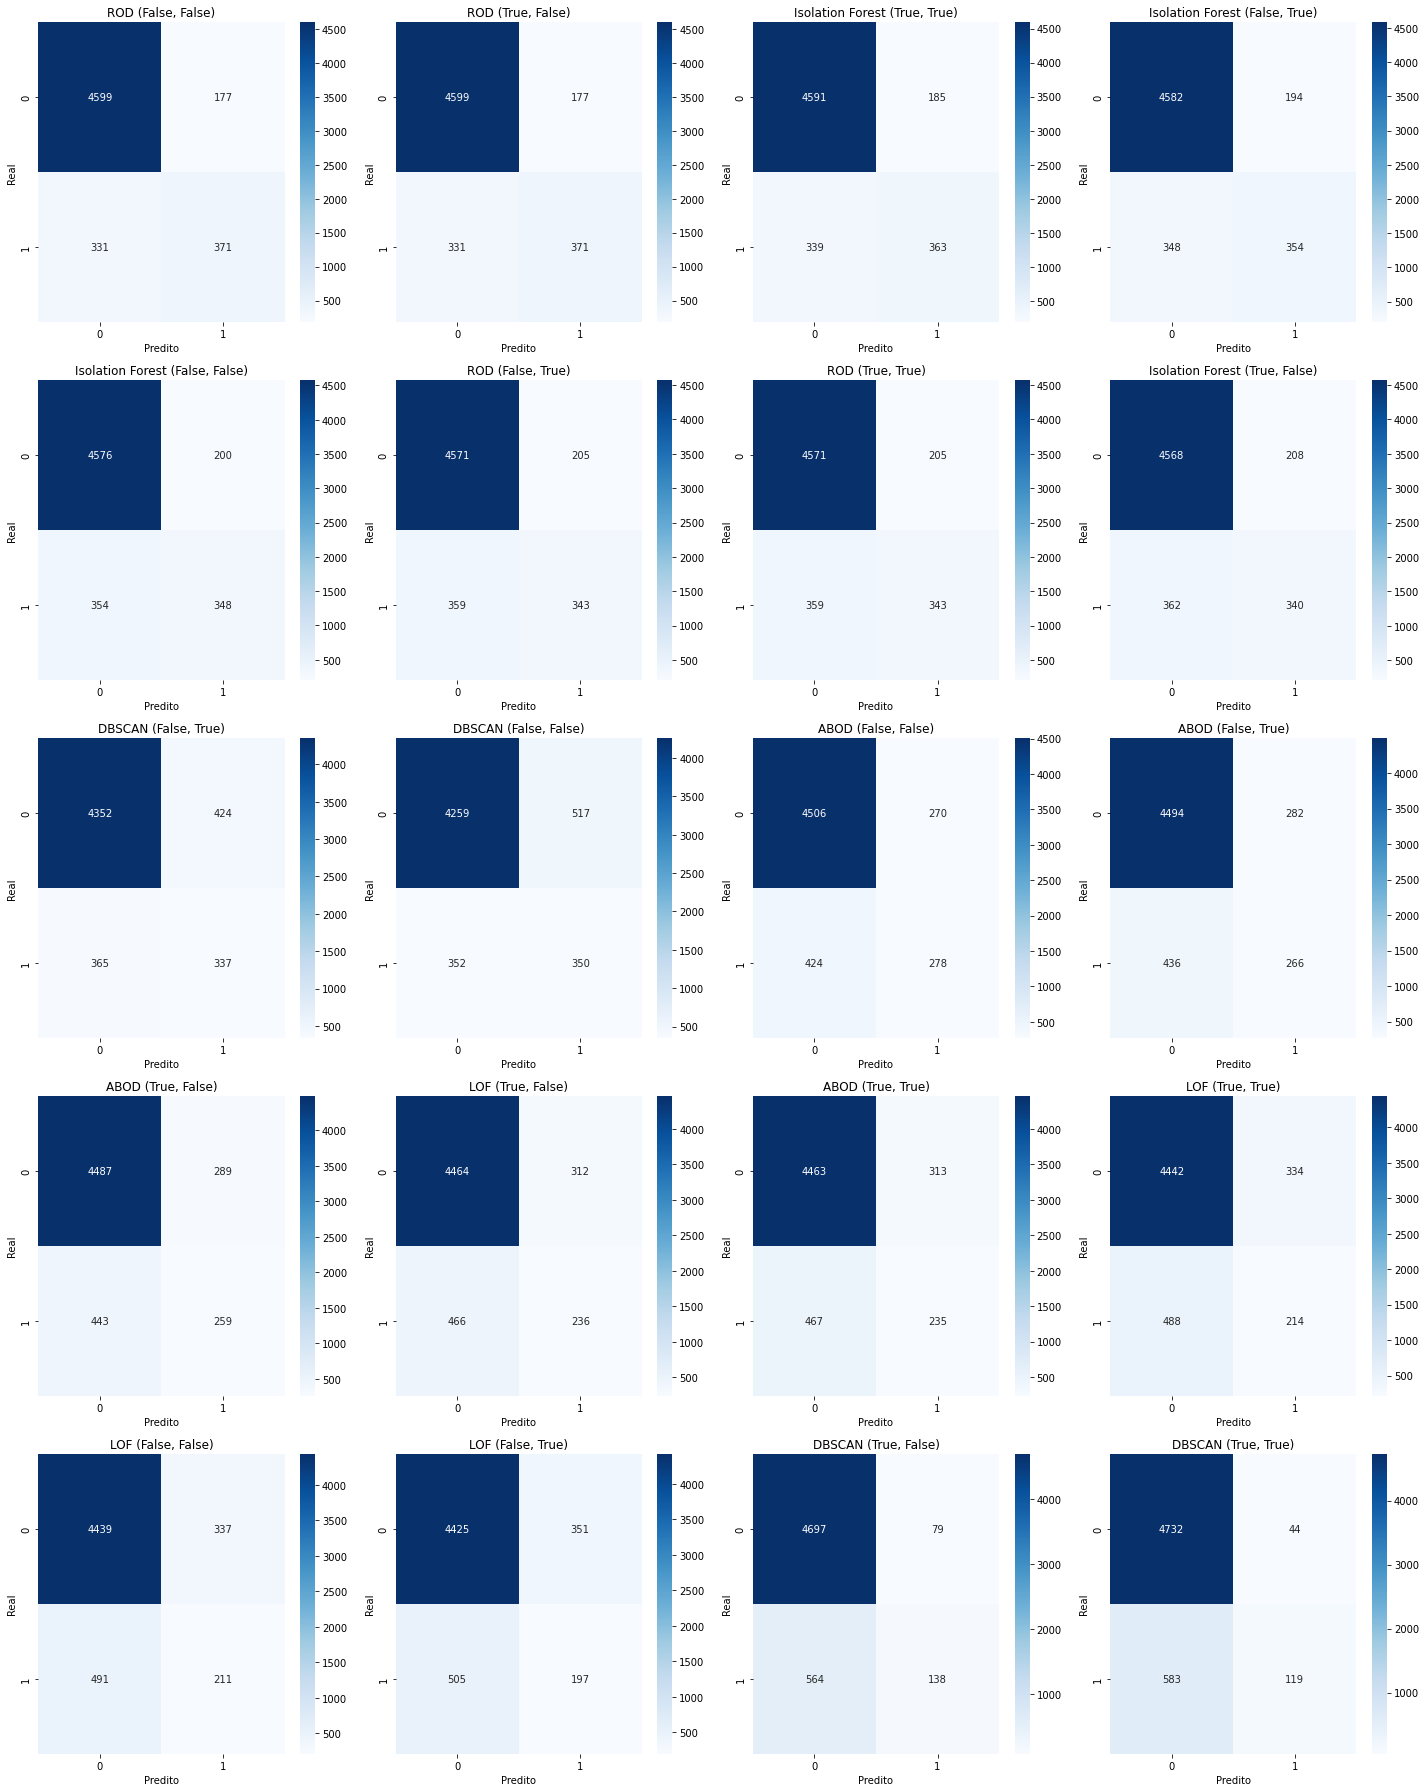

In [29]:
plot_confusion_matrices(results_dict=train_results_dict)

## Resultados nos Dados de Teste

In [30]:
test_report_df

,accuracy,precision,recall,f1,roc_auc
model,,,,,
"Isolation Forest (False, False)",0.879781,0.562500,0.692308,0.620690,0.801568
"Isolation Forest (True, True)",0.907104,0.800000,0.461538,0.585366,0.721215
"Isolation Forest (True, False)",0.909836,0.880000,0.423077,0.571429,0.706761
"ROD (False, False)",0.893443,0.709677,0.423077,0.530120,0.697207
"Isolation Forest (False, True)",0.811475,0.402299,0.673077,0.503597,0.753736
"ABOD (False, False)",0.797814,0.375000,0.634615,0.471429,0.729728
"ROD (False, True)",0.879781,0.633333,0.365385,0.463415,0.665176
"ROD (True, False)",0.874317,0.593750,0.365385,0.452381,0.661992
"LOF (False, False)",0.775956,0.340426,0.615385,0.438356,0.708966


In [31]:
test_results_dict = OrderedDict((k, test_results_dict[k]) for k in test_report_df.index if k in test_results_dict)

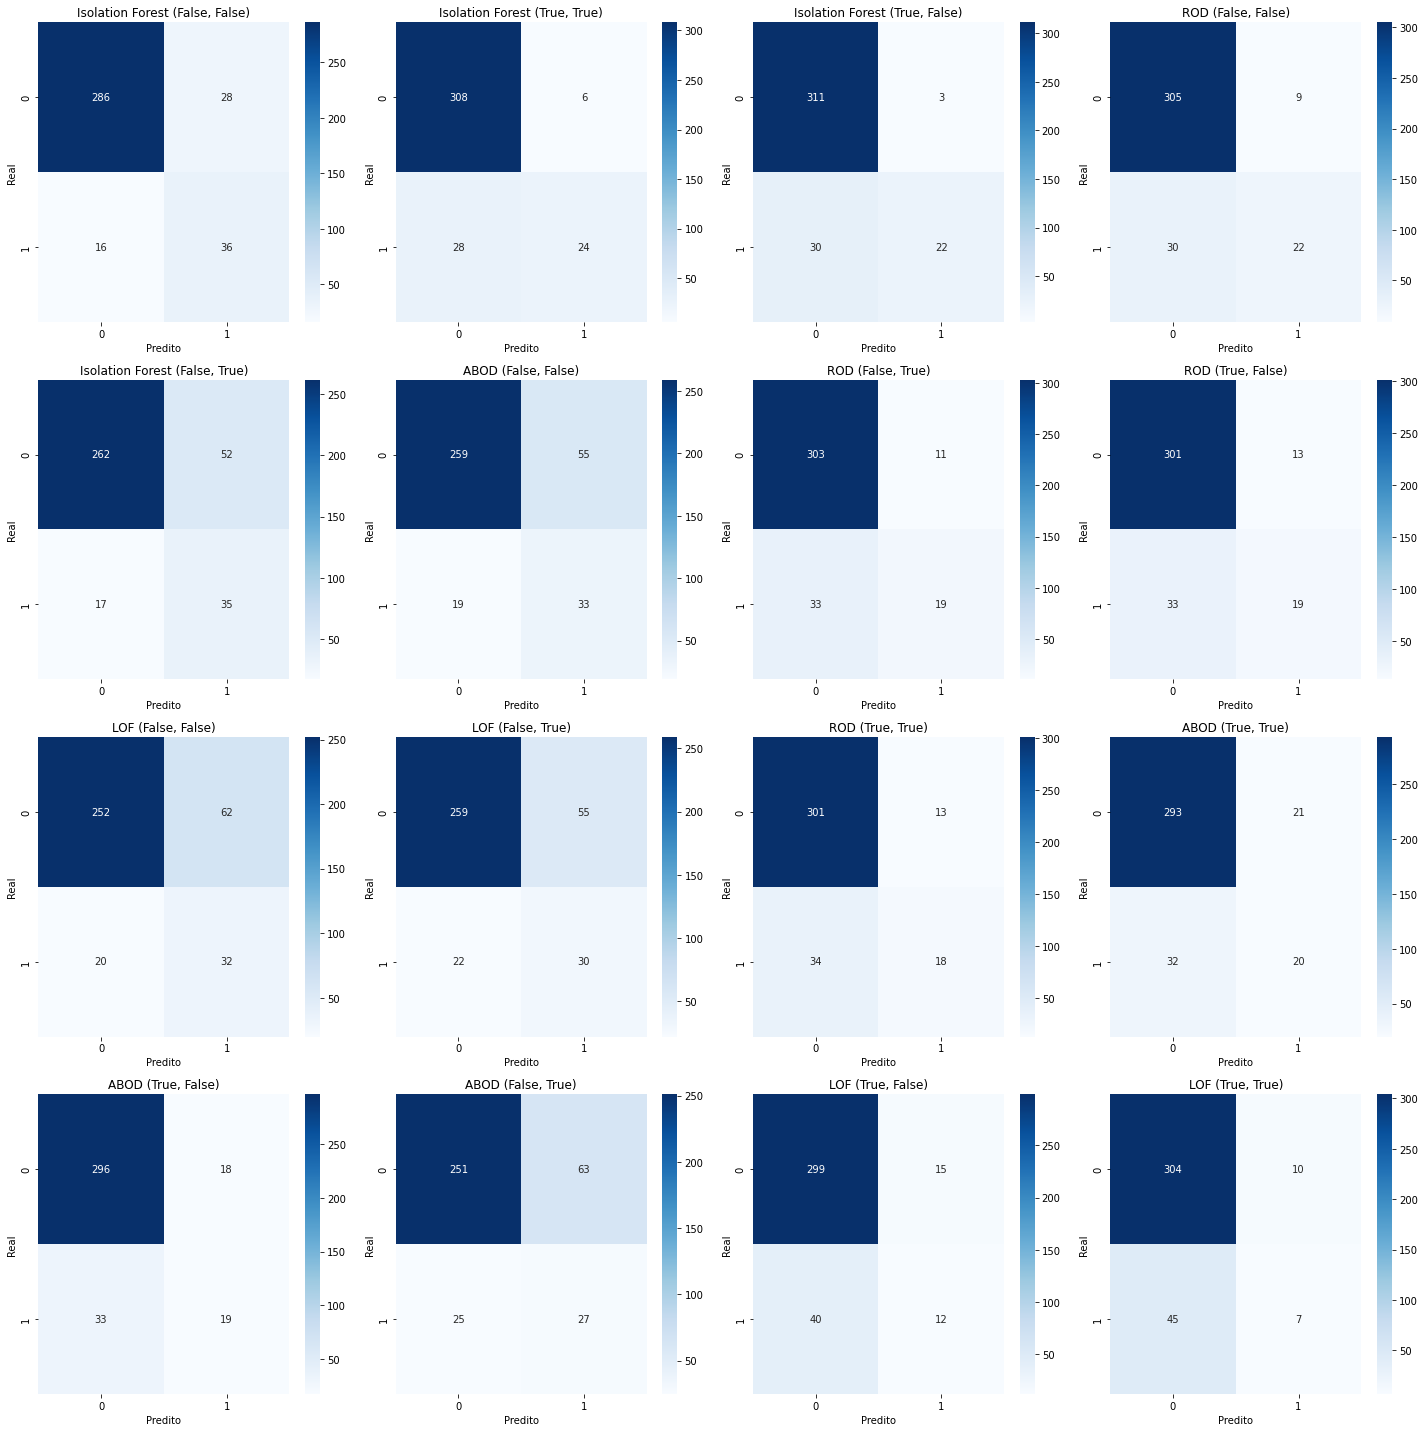

In [32]:
plot_confusion_matrices(results_dict=test_results_dict)

# Interpretação de Resultados

## Feature Importances

In [33]:
test_feature_importance_dict = OrderedDict((k, feature_importance_dict[k]) for k in test_report_df.index if k in feature_importance_dict)

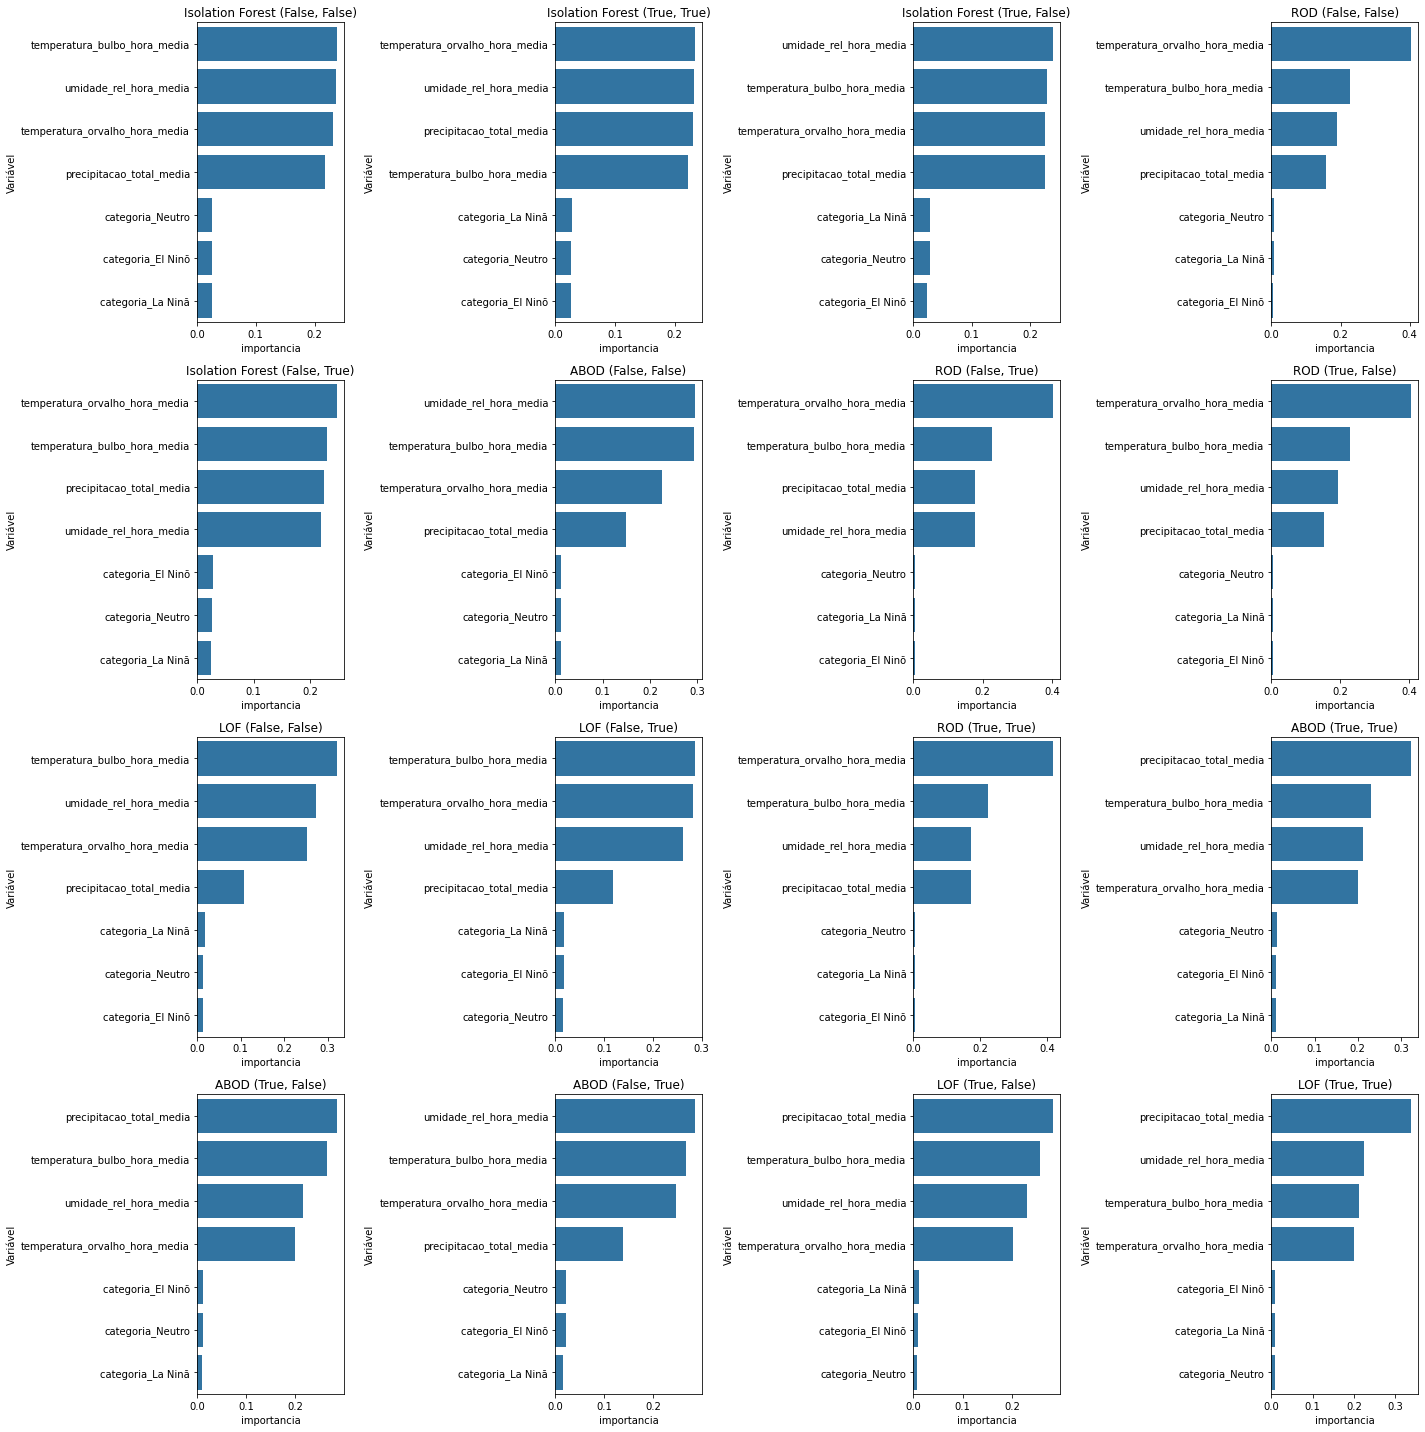

In [ ]:
plot_feature_importances(feature_importance_dict=test_feature_importance_dict)

## SHAP Values

In [35]:
def predict_fn(X):
    return model.decision_function(X)

In [ ]:
test_selected_models = OrderedDict((k, models_dict[k]) for k in test_report_df.index[:5] if k in models_dict)

In [48]:
shap_values_dict = {}

for model_name, model in test_selected_models.items():
    train_data = train_data_dict[model_name][feature_cols]
    test_data = test_data_dict[model_name][feature_cols]

    try:
        print(f"Computing SHAP values for {model_name}")
        # explainer = shap.Explainer(
        #     predict_fn, 
        #     train_data.sample(int(len(train_data) * 0.1)), 
        #     algorithm="permutation")

        explainer = shap.Explainer(model.decision_function, test_data)
        shap_values = explainer(test_data)
        
        shap_values = explainer(test_data[feature_cols])
        shap_values_dict[model_name] = shap_values
    except:
        shap_values_dict[model_name] = None
        print(f"SHAP values not available for {model_name}")
        pass

Computing SHAP values for Isolation Forest (False, False)


ExactExplainer explainer: 367it [00:14,  7.95it/s]                         
ExactExplainer explainer: 367it [00:16,  8.48it/s]                         


Computing SHAP values for Isolation Forest (True, True)


ExactExplainer explainer: 367it [00:16,  8.62it/s]                         
ExactExplainer explainer: 367it [00:13,  6.82it/s]                         


Computing SHAP values for Isolation Forest (True, False)


ExactExplainer explainer: 367it [00:15,  7.66it/s]                         
ExactExplainer explainer: 367it [00:13,  6.28it/s]                         


Computing SHAP values for ROD (False, False)


ExactExplainer explainer: 367it [01:06,  4.72it/s]                         
ExactExplainer explainer: 367it [01:28,  3.60it/s]                         


Computing SHAP values for Isolation Forest (False, True)


ExactExplainer explainer: 367it [00:15,  7.16it/s]                         
ExactExplainer explainer: 367it [00:14,  6.36it/s]                         


In [59]:
def plot_shap_values(shap_values_dict: dict):

    n = len(shap_values_dict)
    n_cols = 2
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten() 

    for idx, (model_name, shap_values) in enumerate(shap_values_dict.items()):
        tmp_fig = plt.figure()
        shap.summary_plot(shap_values, test_data_dict[model_name][feature_cols], show=False)
        canvas = FigureCanvas(tmp_fig)
        canvas.draw()
        
        axes[idx].imshow(canvas.buffer_rgba())
        axes[idx].axis('off')
        axes[idx].set_title(model_name)

        plt.close(tmp_fig) 

    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

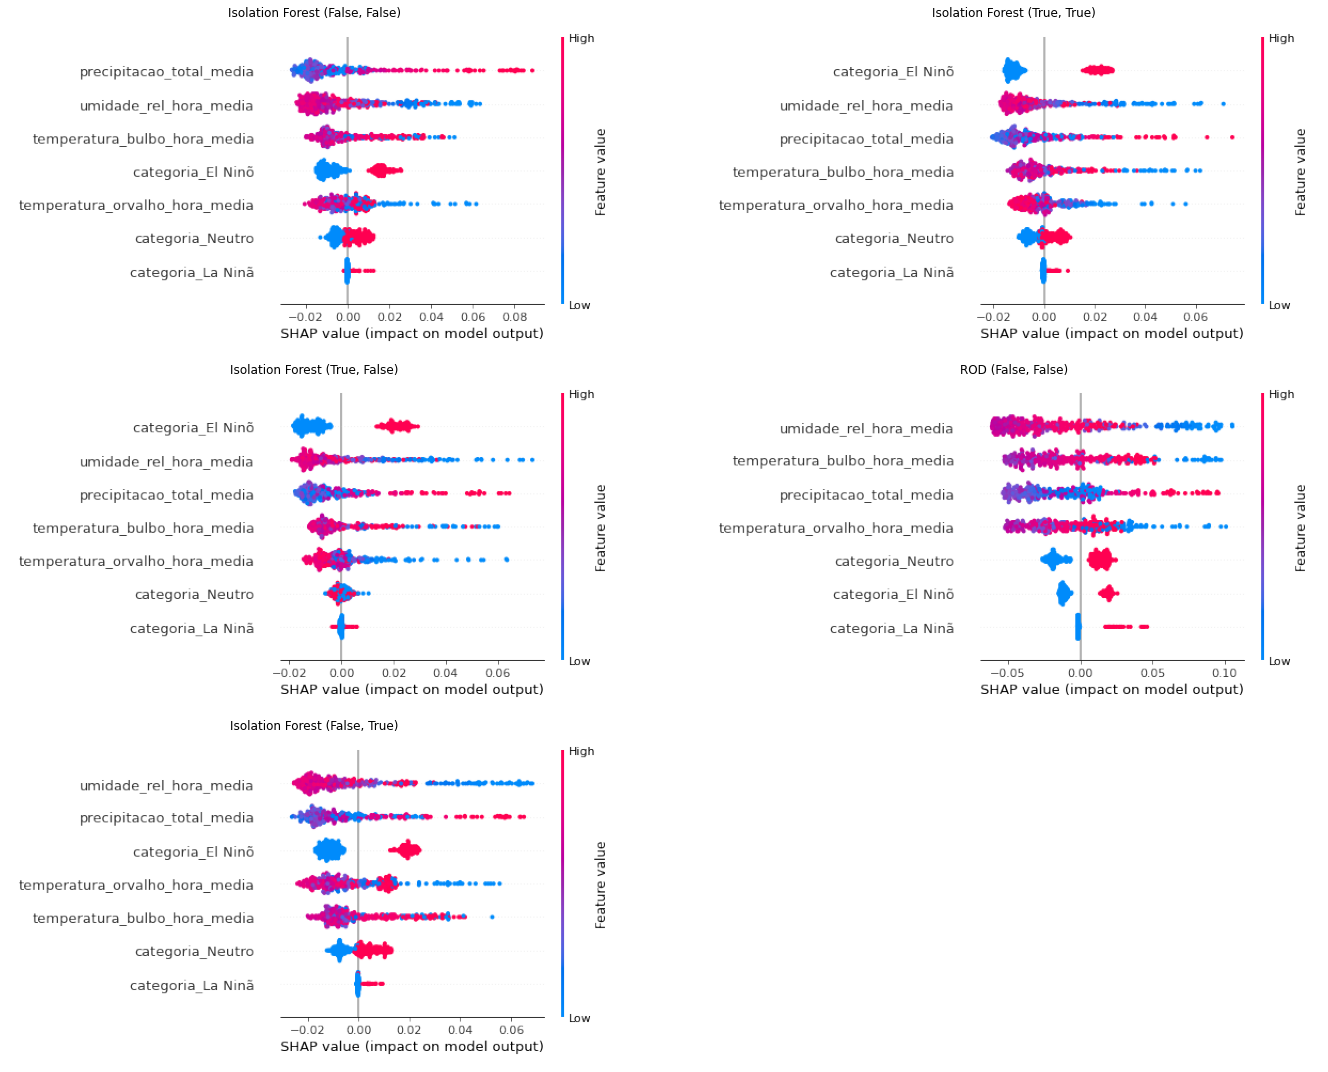

In [60]:
plot_shap_values(shap_values_dict=shap_values_dict)